In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import sys
import geopandas as gpd
from pathlib import Path

notebook_path = Path().resolve()
src_path = notebook_path.parents[1] / 'src'

if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from utils import is_light

In [6]:
df = pd.read_csv("../../data/raw/sociometro-vasco-86-prevision-voto.csv", delimiter=";")
metadata_json_path = Path('../../data/metadata/preguntas.json')
with open(metadata_json_path, 'r', encoding='utf-8') as f:
    metadata = json.load(f)

In [7]:
p22_map = metadata["preguntas"]["P22"]["opciones"]
p22_index_int = {int(k): v for k,v in p22_map.items()}
conteo_elecciones_pasadas= df["p22"].value_counts()
conteo_elecciones_pasadas.index = conteo_elecciones_pasadas.index.map(p22_index_int)
conteo_elecciones_pasadas.name = "Conteo de las elecciones pasadas"
conteo_elecciones_pasadas

p22
PNV/EAJ                                                          814
EH BILDU                                                         649
NO VOTÓ, SE ABSTUVO                                              374
PARTIDO SOCIALISTA DE EUSKADI-PSE-EE                             318
NO CONTESTA                                                      304
NO SABE                                                          131
PP                                                               107
NO PUDO VOTAR POR NO TENER DERECHO                                80
ELKARREKIN PODEMOS                                                74
SUMAR                                                             40
VOTÓ BLANCO                                                       38
VOX                                                               36
OTRA CANDIDATURA                                                  26
VOTÓ NULO                                                         20
NO PUDO VOTAR POR SER MENOR DE

In [8]:
metadata["preguntas"]["P25"]["texto"]

'¿QUÉ GRADO DE SIMPATÍA SIENTE POR CADA UNA DE LAS SIGUIENTES OPCIONES POLÍTICAS, EN UNA ESCALA DE 0 A 10, DONDE EL 0 SIGNIFICA NINGUNA SIMPATÍA Y EL 10 MUCHA SIMPATÍA?'

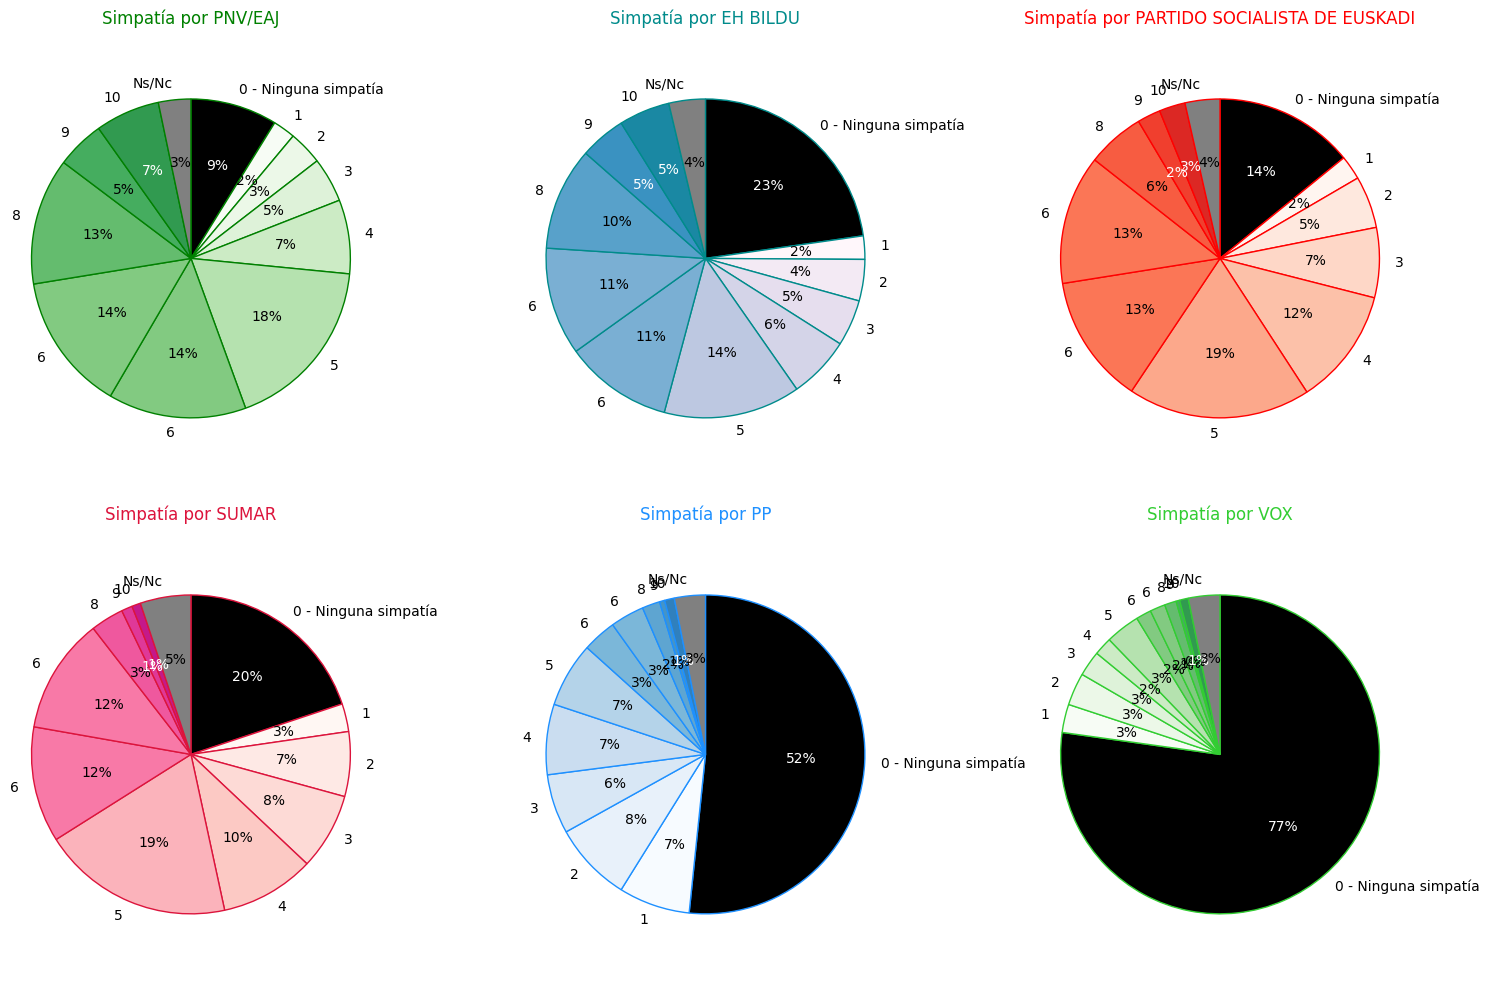

In [9]:
simpatia_partidos_map = {
    0: "0 - Ninguna simpatía",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
    10: "10",
    11: "Ns/Nc",
}

ordered_simpatia_partidos_list = [
    "0 - Ninguna simpatía",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "6",
    "8",
    "9",
    "10",
    "Ns/Nc"

]

partido_colors = {
    "PNV/EAJ": {"colormap": "Greens", "color": "green", "textcolor": "black"},
    "EH BILDU": {"colormap": "PuBuGn", "color": "darkcyan", "textcolor": "black"},
    "PARTIDO SOCIALISTA DE EUSKADI": {"colormap": "Reds", "color": "red", "textcolor": "black"},
    "SUMAR": {"colormap": "RdPu", "color": "crimson", "textcolor": "black"},
    "PP": {"colormap": "Blues", "color": "dodgerblue", "textcolor": "black"},
    "VOX": {"colormap": "Greens", "color": "limegreen", "textcolor": "black"},
}

p25_list = metadata["preguntas"]["P25"]["partidos"]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (partido, ax) in enumerate(zip(p25_list, axes)):
    col_number = f"p250{i+1}"
    data = df[col_number].value_counts()

    data.index = data.index.map(simpatia_partidos_map)
    data = data.reindex(ordered_simpatia_partidos_list, fill_value=0)

    # En este caso no aplica
    data = data[data > 0]

    estilo = partido_colors.get(partido, {"colormap": "Oranges", "color": "orange"})

    colormap = plt.get_cmap(estilo["colormap"], 14)
    colors = [colormap(i) for i in range(11)]
    colors.insert(0, "black")
    colors.insert(11, "grey")

    # Creamos el mapeo de colores
    color_map = {label: color for label, color in zip(ordered_simpatia_partidos_list, colors)}
    slice_colors = [color_map[label] for label in data.index]

    text_colors = ['black' if is_light(color) else 'white' for color in slice_colors]

    wedges, texts, autotexts = ax.pie(
        data,
        labels=data.index,
        colors=slice_colors,
        autopct='%1.0f%%',
        textprops={'color': 'black'},
        startangle=90,  # Comenzamos en la parte superior
        counterclock=False,  # Orden en sentido horario
        wedgeprops={'linewidth': 1, 'edgecolor': estilo['color']}
    )

    # Ajustamos colores del texto
    for autotext, color in zip(autotexts, text_colors):
        autotext.set_color(color)

    ax.set_title(f"Simpatía por {partido}", color=estilo["color"])
    ax.axis('equal')

plt.tight_layout()
plt.show()


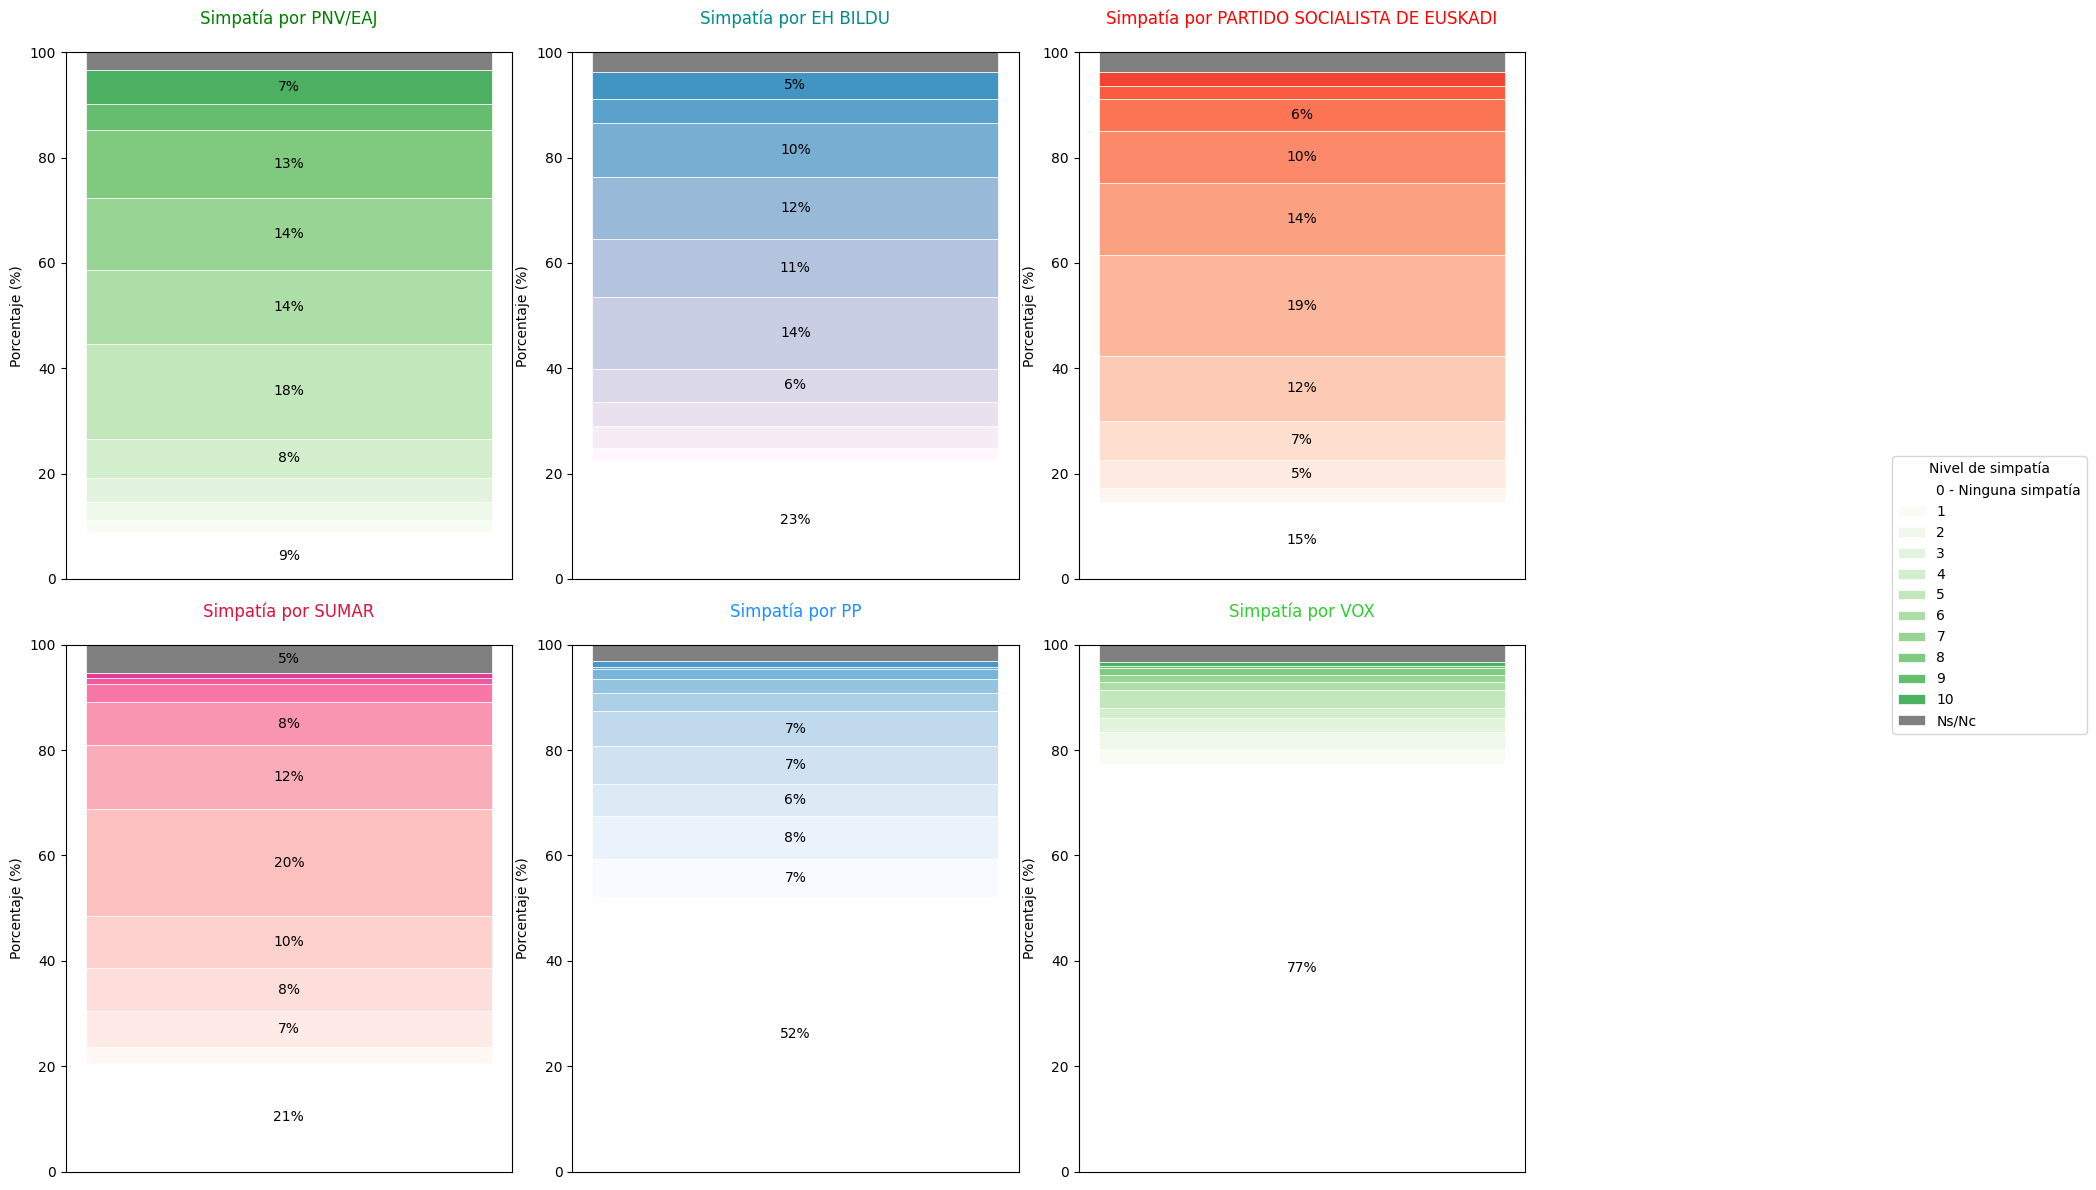

In [14]:
import numpy as np
p25_list = metadata["preguntas"]["P25"]["partidos"]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (partido, ax) in enumerate(zip(p25_list, axes)):
    col_number = f"p250{i+1}"
    data = df[col_number].value_counts(normalize=True) * 100  # Convertir a porcentaje
    
    data.index = data.index.map(simpatia_partidos_map)
    data = data.reindex(ordered_simpatia_partidos_list, fill_value=0)
    
    # Ordenamos los datos según la lista ordenada
    data = data[ordered_simpatia_partidos_list]
    
    estilo = partido_colors.get(partido, {"colormap": "Oranges", "color": "orange"})
    
    # Preparar colores
    colormap = plt.get_cmap(estilo["colormap"], 16)
    colors = [colormap(i) for i in range(11)]
    colors.insert(0, "white")
    colors.insert(11, "grey")
    color_map = {label: color for label, color in zip(ordered_simpatia_partidos_list, colors)}
    
    # Crear gráfico de barras apiladas
    bottom = np.zeros(1)  # Solo una barra por partido
    for j, (label, value) in enumerate(data.items()):
        ax.bar(0, value, bottom=bottom, color=color_map[label], label=label, edgecolor='white', linewidth=0.5)
        bottom += value
    
    # Configuración del gráfico
    ax.set_title(f"Simpatía por {partido}", color=estilo["color"], pad=20)
    ax.set_xticks([])  # Eliminar ticks del eje x
    ax.set_ylim(0, 100)  # Eje y de 0 a 100%
    ax.set_ylabel('Porcentaje (%)')
    
    # Mostrar porcentajes dentro de las barras si son suficientemente grandes
    bottom = 0
    for j, (label, value) in enumerate(data.items()):
        if value > 5:  # Solo mostrar etiquetas para segmentos >5%
            ax.text(0, bottom + value/2, f"{value:.0f}%", 
                   ha='center', va='center', 
                   color='white' if not is_light(color_map[label]) else 'black')
        bottom += value

# Crear leyenda común
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='Nivel de simpatía', 
           bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Hacer espacio para la leyenda
plt.show()

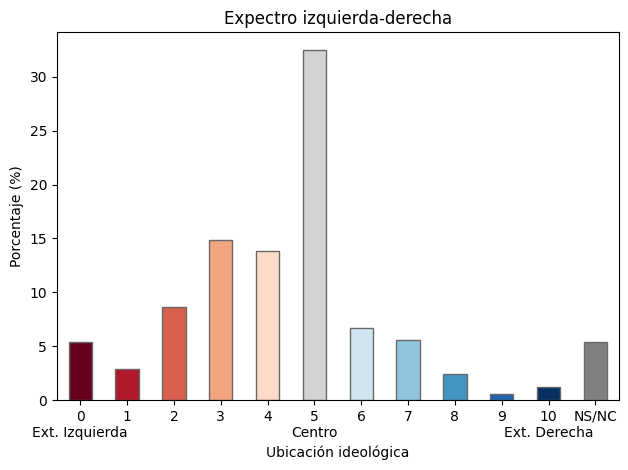

In [ ]:
p32_text = metadata["preguntas"]["P32"]["texto"]
etiquetas_p32 = {
 0:    "0\nExt. Izquierda",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5\nCentro",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
    10: "10\nExt. Derecha",
    11: "NS/NC"
}
colores_gradiente = [plt.get_cmap('RdBu')(i / 10) for i in range(11)]
colores_gradiente[5] = "lightgray"
colores_gradiente.append("gray")
conteo_izquierda_derecha = df["p32"].value_counts(normalize=True) * 100
conteo_izquierda_derecha = conteo_izquierda_derecha.sort_index(ascending=True)
conteo_izquierda_derecha.index = conteo_izquierda_derecha.index.map(etiquetas_p32)
ax = conteo_izquierda_derecha.plot(kind='bar', color=colores_gradiente, title="Expectro izquierda-derecha", edgecolor="dimgray")
ax.set_ylabel("Porcentaje (%)")
ax.set_xlabel("Ubicación ideológica")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

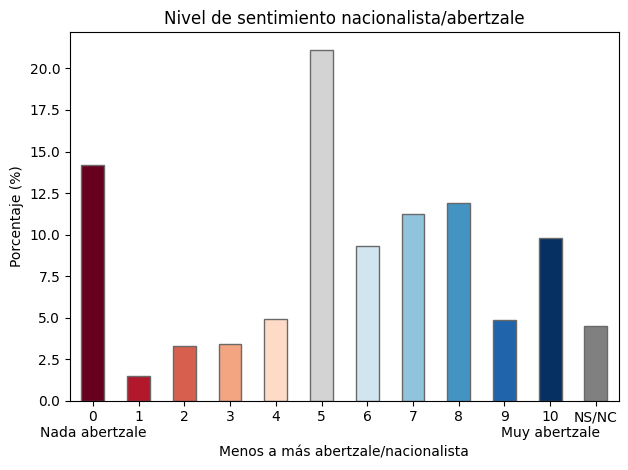

In [ ]:
etiquetas_p33 = {
 0:    "0\nNada abertzale",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
    10: "10\nMuy abertzale",
    11: "NS/NC"
}
colores_gradiente = [plt.get_cmap('RdBu')(i / 10) for i in range(11)]
colores_gradiente[5] = "lightgray"
colores_gradiente.append("gray")
conteo_sentimiento_aberzale = df["p33"].value_counts(normalize=True) * 100
conteo_sentimiento_aberzale = conteo_sentimiento_aberzale.sort_index(ascending=True)
conteo_sentimiento_aberzale.index = conteo_sentimiento_aberzale.index.map(etiquetas_p33)
ax = conteo_sentimiento_aberzale.plot(kind='bar', color=colores_gradiente, title="Nivel de sentimiento nacionalista/abertzale", edgecolor="dimgray")
ax.set_ylabel("Porcentaje (%)")
ax.set_xlabel("Menos a más abertzale/nacionalista")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

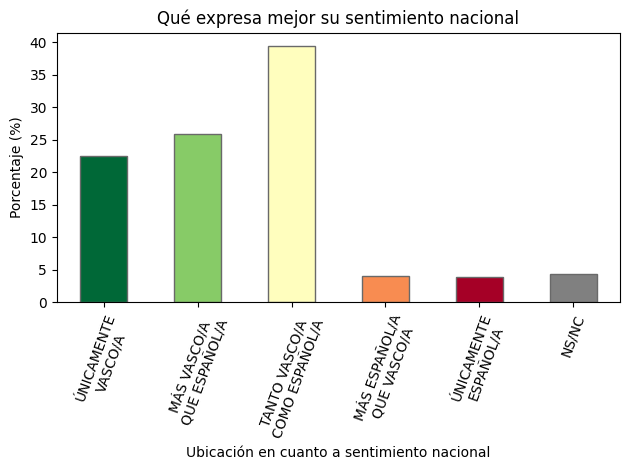

In [ ]:
etiquetas_p34 = {
    1: "ÚNICAMENTE\nVASCO/A",
    2: "MÁS VASCO/A\nQUE ESPAÑOL/A",
    3: "TANTO VASCO/A\nCOMO ESPAÑOL/A",
    4: "MÁS ESPAÑOL/A\nQUE VASCO/A",
    5: "ÚNICAMENTE\nESPAÑOL/A",
    6: "NS/NC"
}

colores_gradiente = [plt.get_cmap('RdYlGn_r')(i /4) for i in range(5)]
colores_gradiente.append("gray")
conteo_sentimiento_nacional = df["p34"].value_counts(normalize=True) * 100
conteo_sentimiento_nacional = conteo_sentimiento_nacional.sort_index(ascending=True)
conteo_sentimiento_nacional.index = conteo_sentimiento_nacional.index.map(etiquetas_p34)
ax = conteo_sentimiento_nacional.plot(kind='bar', color=colores_gradiente, title="Qué expresa mejor su sentimiento nacional", edgecolor="dimgray")
ax.set_ylabel("Porcentaje (%)")
ax.set_xlabel("Ubicación en cuanto a sentimiento nacional")
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

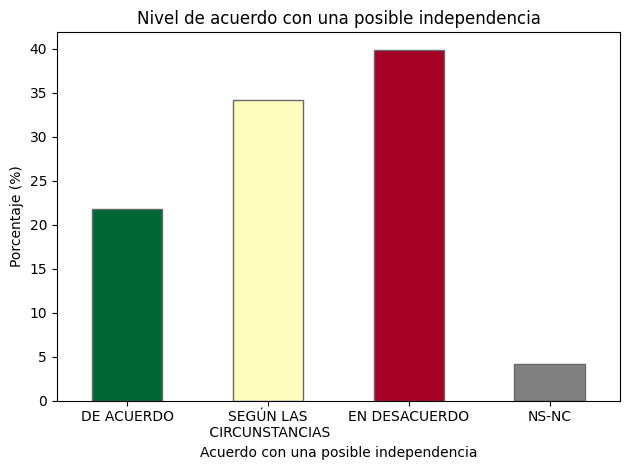

p35
DE ACUERDO                    21.749175
SEGÚN LAS\n CIRCUNSTANCIAS    34.158416
EN DESACUERDO                 39.900990
NS-NC                          4.191419
Name: proportion, dtype: float64

In [ ]:
etiquetas_p35 = {
          1: "DE ACUERDO",
          2: "SEGÚN LAS\n CIRCUNSTANCIAS",
          3: "EN DESACUERDO",
          4: "NS-NC"
}

colores_gradiente = [plt.get_cmap('RdYlGn_r')(i /2) for i in range(3)]
colores_gradiente.append("gray")
conteo_acuerdo_independencia = df["p35"].value_counts(normalize=True) * 100
conteo_acuerdo_independencia = conteo_acuerdo_independencia.sort_index(ascending=True)
conteo_acuerdo_independencia.index = conteo_acuerdo_independencia.index.map(etiquetas_p35)
ax = conteo_acuerdo_independencia.plot(kind='bar', color=colores_gradiente, title="Nivel de acuerdo con una posible independencia", edgecolor="dimgray")
ax.set_ylabel("Porcentaje (%)")
ax.set_xlabel("Acuerdo con una posible independencia")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
conteo_acuerdo_independencia

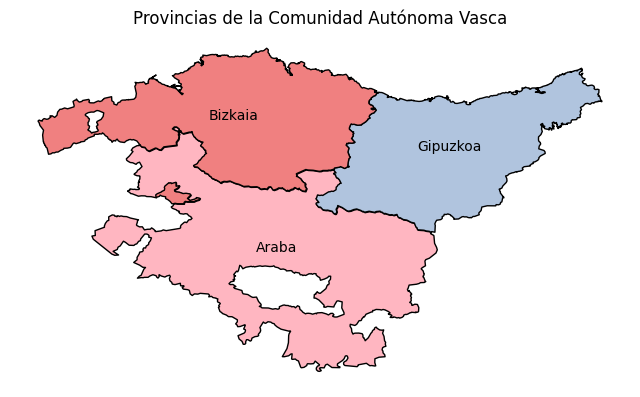

In [ ]:
gdf = gpd.read_file("../../data/raw/euskadi.geojson")
provincias_map = {
    "Vizcaya"   : {"name": "Bizkaia",   "color": "lightcoral"},
    "Guipúzcoa" : {"name": "Gipuzkoa",  "color": "lightsteelblue"},
    "Álava"     : {"name": "Araba",     "color": "lightpink"}
}
fig, ax = plt.subplots(figsize=(8, 8))

for idx, row in gdf.iterrows():
    provincia = row["Texto"]
    color = provincias_map[provincia]["color"]
    row_geometry = gpd.GeoSeries([row.geometry])
    row_geometry.plot(ax=ax, color=color, edgecolor="black")

    nombre = provincias_map[provincia]["name"]
    centroid = row.geometry.centroid
    plt.annotate(text=nombre, xy=(centroid.x, centroid.y),
                 horizontalalignment='center', fontsize=10)

plt.title("Provincias de la Comunidad Autónoma Vasca")
plt.axis("off")
plt.show()
